# Этап 1. Получение данных

Изучим данные, предоставленные сервисом для проекта.
Выведем общую инфорацию по датасетам. Для нескольких файлов это удобнее делать через функцию.

In [1]:
# Импорт библиотек
from scipy import stats as st
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import math

data_users = pd.read_csv('/datasets/users.csv')
data_calls = pd.read_csv('/datasets/calls.csv')
data_internet = pd.read_csv('/datasets/internet.csv')
data_messages = pd.read_csv('/datasets/messages.csv')
data_tariffs = pd.read_csv('/datasets/tariffs.csv')

def table_info():
    for table in [data_users, data_calls, data_internet, data_messages, data_tariffs]:
        print(table.info())
        print()

table_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    14939

Рассмотрим полученную информацию подробнее.

В представленных данных 5 таблиц с данными о:
- пользователях (data_users);
- звонках (data_calls);
- интернет-сессиях (data_internet);
- отправленных сообщениях (data_messages);
- тарифах (data_tariffs).

Переименуем столбцы таблиц, чтобы не путаться в названиях.

In [2]:
data_calls.columns = ['call_id', 'call_date', 'call_duration', 'user_id']
data_internet.columns = ['ind','internet_id','mb_used', 'internet_date', 'user_id']
data_messages.columns = ['message_id', 'message_date', 'user_id']
data_tariffs.columns = ['messages_included', 'mg_per_month_included', 'minutes_included', 'rub_monthly_fee', 
                       'rub_per_gb', 'rub_per_message', 'rub_per_minute','tariff']

Для дальнейшей работы с данными необходимо обработать пропуски в датах и поменять тип данных на нужный.

# Этап 2. Подготовка данных

В данных о пользователях есть пропуски в дате прекращения пользония тарифом. Так как представленная выгрузка за 2018 год, предположим, что тариф действовал до 01.01.2019:

In [3]:
data_users['churn_date'] = data_users['churn_date'].fillna('2019-01-01')

Поменяем тип данных в таблицах о звонках и интрернет-трафике на нужные. Для этого напишем функцию ceil для коррекктного округления в бОльшую сторону.

In [4]:
def ceil(x):
    return math.ceil(x)

data_calls['call_id'] = data_calls['call_id'].astype('object')

data_calls['call_duration'] = data_calls['call_duration'].apply(ceil).astype('int')
data_internet['mb_used'] = data_internet['mb_used'].apply(ceil).astype('int')

В таблице звонков есть нулевые значения продолжительности разговора: так как в тарифах оператора указана поминутная тарификация, то даже если звонок продолжается несколько секунд, оператор посчитает целую минуту:

In [5]:
data_calls.loc[data_calls['call_duration'] == 0, 'call_duration'] = 1

Добавим в каждую таблицу по звонкам, интернет-трафику и сообщениях столбец с месяцем

In [6]:
def add_month(data, column):
    data['month'] = pd.DatetimeIndex(data[column]).month
    
add_month(data_calls, 'call_date')
add_month(data_internet, 'internet_date')
add_month(data_messages, 'message_date')

Посмотрим на количество сделанных звонков, израсходованных минут и интернет-трафика по каждому пользователю в месяц:

In [7]:
# Количество сделанных звонков и израсходованных минут по каждому пользователю в месяц:
data_calls = data_calls.pivot_table(index=['user_id','month'], 
                                    values = ['call_duration'], 
                                    aggfunc = ['sum','count']).reset_index() 
data_calls.columns = ['user_id', 'month','call_duration','count_calls']

# Количество отправленных сообщений по месяцам:
data_messages = data_messages.pivot_table(index=['user_id','month'], 
                                          values = ['message_date'], 
                                          aggfunc = ['count']).reset_index() 
data_messages.columns = ['user_id', 'month','count_message']

# Объем израсходованного интернет-трафика по месяцам:
data_internet = data_internet.pivot_table(index=['user_id','month'], 
                                          values = ['mb_used'], 
                                          aggfunc = ['sum']).reset_index() 
data_internet.columns = ['user_id', 'month','volume_mb']

Соберем в одну таблицу количество сделанных звонков, израсходованных минут, отправленных сообщений и израсходованного интернет-трафика по каждому пользователю в месяц (data).

In [8]:
data = (data_calls.merge(data_messages, on=['user_id','month'], how='outer')
                  .merge(data_internet, on=['user_id','month'], how='outer')
                  .fillna(0))

data.dropna(subset=['count_calls','count_message','volume_mb'], inplace=True)

data.head()

,user_id,month,call_duration,count_calls,count_message,volume_mb
0,1000,5,164.0,22.0,22.0,2256.0
1,1000,6,187.0,43.0,60.0,23257.0
2,1000,7,346.0,47.0,75.0,14016.0
3,1000,8,418.0,52.0,81.0,14070.0
4,1000,9,478.0,58.0,57.0,14581.0


<font color='green'>Данные собраны верно.

Построим гистограммы, чтобы посмотреть, если ли в данных выбросы. Для этого напишем функцию hist().

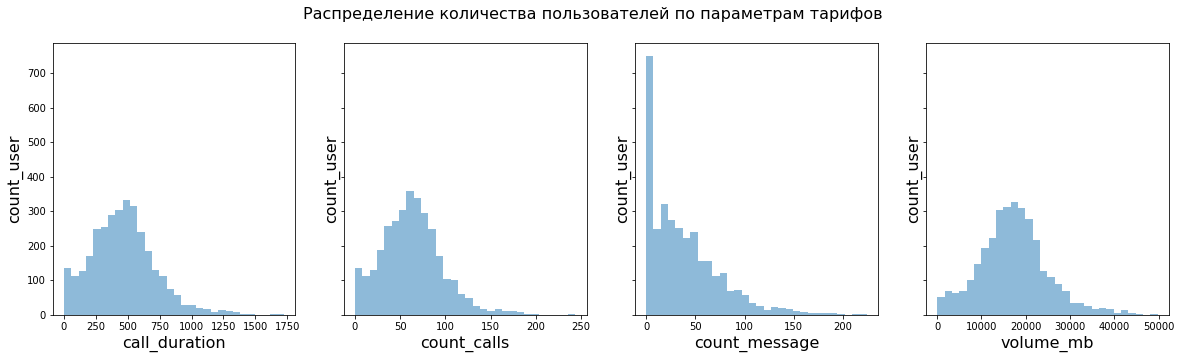

In [9]:
def hist():
    list = ['call_duration', 'count_calls', 'count_message', 'volume_mb']
    fig, axs = plt.subplots(1, len(list), figsize=(20, 5), sharey=True)
    fig.suptitle('Распределение количества пользователей по параметрам тарифов', fontsize=16)
    for i in list:
        axs[list.index(i)].hist(data[i], bins = 30, alpha = 0.5)
        axs[list.index(i)].set_ylabel('count_user', fontsize=16)
        axs[list.index(i)].set_xlabel(i, fontsize=16)
        
hist()

Как же распределены данные? 
Видно, что у некоторых пользователей количество минут разговара превышает 1000 минут (более 16 часов) в месяц. Кол-во звонков превышает более 120 в месяц - это, на мой взгляд, аномалия. При этом есть аномальный выброс у пользователей в диапазоне от 0 до 7 сообщений, а некоторые пользователи отправляют более 150 смс в месяц. А также трафик более 40'000 mb выглядит подозрительно.
Добавим данные о тарифах и избавимся от выбросов.

In [10]:
data_tariff = data.merge(data_users, on=['user_id'], how='outer')
data = data_tariff[['user_id', 'month','call_duration','count_calls','count_message','volume_mb','tariff']]

data = data.query('call_duration <= 1000 and count_calls <= 120 and 7 <= count_message <= 150 and volume_mb <= 40000')

Проверка на наличие выбросов после корректировки

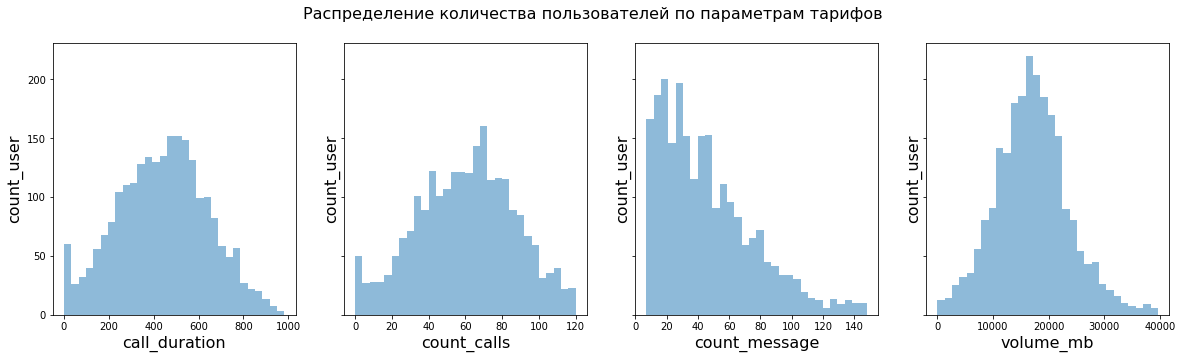

In [11]:
hist()

Далее определим тариф каждого пользователя и лимит по нему. Это необходимо для расчета выручки по каждому клиенту помесячно: как произведение остатка тарифа на его стоимость.

Text(0.5, 0.98, 'Распределение выручки по тарифам')

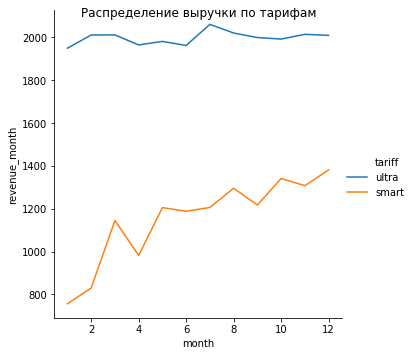

In [12]:
data_result = data.merge(data_tariffs, on = 'tariff', how='outer')

# Определяем остаток:
data_result['balance_message'] = data_result['count_message'] - data_result['messages_included'] 
data_result['balance_minute'] = data_result['call_duration'] - data_result['minutes_included']
data_result['balance_mb'] = data_result['volume_mb'] - data_result['mg_per_month_included']

# Если остаток меньше нуля, это значит, что клиент не израсходовал бесплатный лимит
data_result.loc[data_result['balance_message'] < 0, 'balance_message'] = 0
data_result.loc[data_result['balance_minute'] < 0, 'balance_minute'] = 0
data_result.loc[data_result['balance_mb'] < 0, 'balance_mb'] = 0

# Расчет выручки по каждому клиенту \ месяцу:
data_result['revenue_month'] = (data_result['rub_monthly_fee'] 
                                + data_result['balance_message'] * data_result['rub_per_message']
                                + data_result['balance_minute'] * data_result['rub_per_minute']
                                + data_result['balance_mb'] * (data_result['rub_per_gb'] / 1024))

data_revenue = data_result[['user_id','month','revenue_month','tariff']]

sns.relplot(x="month", 
            y="revenue_month", 
            kind="line", 
            hue = 'tariff', 
            data=data_revenue, 
            ci=None).fig.suptitle("Распределение выручки по тарифам", fontsize=12)

Text(0.5, 1.0, 'Распределение выручки тарифов помесячно')

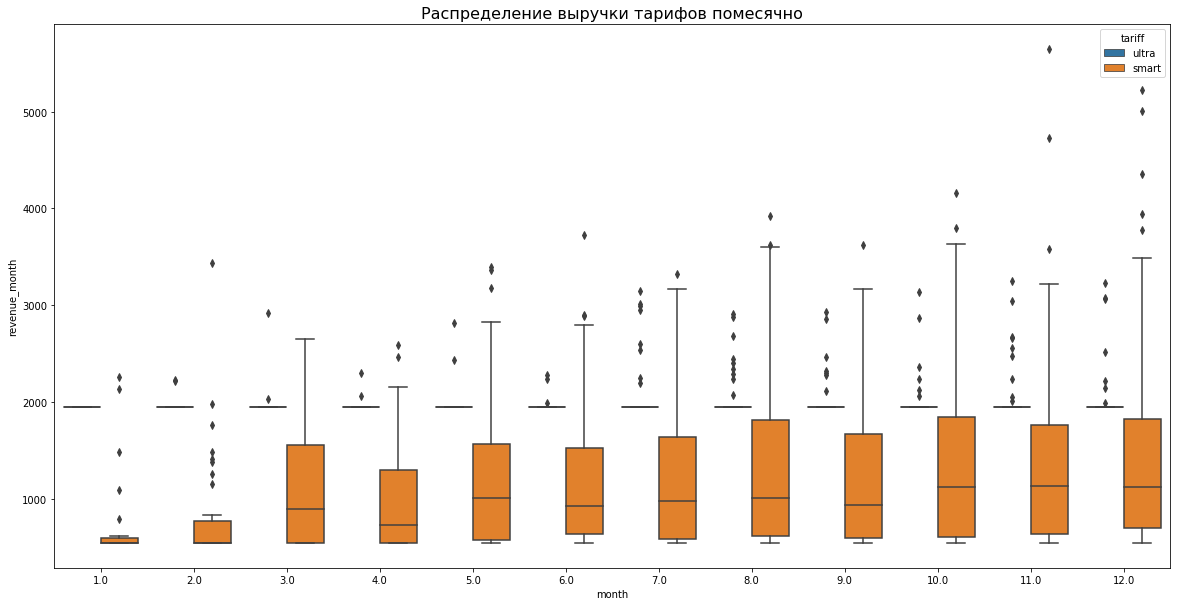

In [13]:
plt.figure(figsize=(20,10))
sns.boxplot(x="month", y="revenue_month",
            hue="tariff",
            data=data_revenue).set_title("Распределение выручки тарифов помесячно", fontsize=16)

In [14]:
data_revenue.groupby('tariff')['revenue_month'].mean()

tariff
smart    1246.000138
ultra    2004.305639
Name: revenue_month, dtype: float64

По графику выше видно, что выручка по Ultra с течением времени почти не колебалась и оставалась на одном уровне, тогда как выручка по второму тарифу росла по месяцам. Итого, средняя выручка по тарифу Smart ниже, чем по Ultra. 

# Этап 3. Анализ данных

Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

In [15]:
data_analysis = data.groupby(by=['tariff'])['call_duration','count_calls','count_message','volume_mb']

print('СРЕДНЕЕ ЗНАЧЕНИЕ')
data_analysis_mean = data_analysis.mean()
print(np.round(data_analysis.mean(), 2).reset_index())
print()

print('ДИСПЕРСИЯ')
data_analysis_var = data_analysis.var()
print(np.round(data_analysis.var(), 2).reset_index())
print()

print('СТАНДАРТНОЕ ОТКЛОНЕНИЕ')
data_analysis_std = data_analysis.std()
print(np.round(data_analysis.std(), 2).reset_index())
print()

СРЕДНЕЕ ЗНАЧЕНИЕ
  tariff  call_duration  count_calls  count_message  volume_mb
0  smart         435.66        59.26          41.75   16557.19
1  ultra         453.76        61.52          58.01   18716.92

ДИСПЕРСИЯ
  tariff  call_duration  count_calls  count_message    volume_mb
0  smart       32542.12       570.30         663.74  28455864.72
1  ultra       62448.05      1100.03        1343.48  83121442.11

СТАНДАРТНОЕ ОТКЛОНЕНИЕ
  tariff  call_duration  count_calls  count_message  volume_mb
0  smart         180.39        23.88          25.76     5334.4
1  ultra         249.90        33.17          36.65     9117.1



Сразу видно, что в среднем по тарифу Ultra никогда не превышат лимит ни по одному из параметров, а по тарифу Smart в среднем пользователи всегда на границе лимита - есть риск докупки минут, сообщений и траффика.

Посмотрим распределение тарифов на графиках.

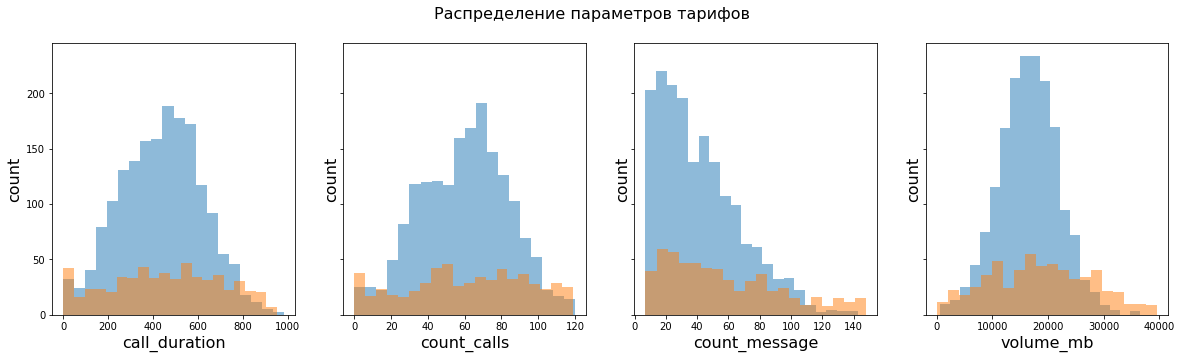

In [16]:
data_smart = data.query('tariff == "smart"')
data_ultra = data.query('tariff == "ultra"')

def tariff_hist():
    list = ['call_duration', 'count_calls', 'count_message', 'volume_mb']
    fig, axs = plt.subplots(1, len(list), figsize=(20, 5), sharey=True)
    fig.suptitle('Распределение параметров тарифов', fontsize=16)
    for i in list:
        axs[list.index(i)].hist(data_smart[i], bins = 20, alpha = 0.5)
        axs[list.index(i)].hist(data_ultra[i], bins = 20, alpha = 0.5)
        axs[list.index(i)].set_ylabel('count', fontsize=16)
        axs[list.index(i)].set_xlabel(i, fontsize=16)
        
tariff_hist()

- **Длительность разговора**: для тарифа Smart больше всего пользователей тратят на разговор от 200 до 600 минут (3 - 10 часов) в среднем в месяц. Тогда как по тарифу Ultra пользователи равнометро распределены по количеству минут разговора, кроме этого по пользователи по тарифу Smart чаще разговаривают по телефону, чем по тарифу Ultra. Пользователи тарифа Smart чаще всего докупают количество минут разговора, а потльзователи Ultra никогда не превышают лимит (50 ч.)

- **Количество звонков**: для тарифа Smart больше всего пользователей совершают от 55 до 80 звонков в среднем за месяц. Тогда как по тарифу Ultra пользователи равнометро распределены по количеству минут разговора. Кроме того, по пользователи по тарифу Smart чаще разговаривают по телефону, чем по тарифу Ultra.

- **Количество сообщений**: по тарифу Smart количество сообщений в месяц в среднем превышает тариф Ultra, а вот более 120 сообщений в месяц отправляют только пользователи Smart. Пользователи тарифа Smart чаще всего докупают количество сообщений, а потльзователи Ultra никогда не превышают лимит (1000)

- **Объем трафика**: для тарифа Smart больше использовано трафика интернета в среднем за месяц, часто пользователям не хватает трафика (15 гб), они его докупают. По тарифу Ultra пользователи равнометро распределены использованному трафику.

# Этап 4. Проверка гипотез

Проверим следующую гипотезу: \
*H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.*

In [17]:
revenue_smart = data_revenue.query('tariff == "smart"')['revenue_month']
revenue_ultra = data_revenue.query('tariff == "ultra"')['revenue_month']

# Критический уровень статистической значимости. Если p-value будет меньше него, нужно отвергнуть гипотезу
alpha = 0.05 

# Проверка гипотезы о равенстве средних двух совокупностей
results = st.ttest_ind(revenue_ultra, revenue_smart)    

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.309363365371783e-115
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу. Средняя выручка по тарифу ultra выше (в основном засчет АП)

Проверим следующую гипотезу: \
*H0 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов*

In [18]:
data_revenue_city = data_revenue.merge(data_users[['user_id','city']], on='user_id', how='left')

revenue_moscow = data_revenue_city.query('city == "Москва"')['revenue_month']
revenue_other = data_revenue_city.query('city != "Москва"')['revenue_month']

# Критический уровень статистической значимости. Если p-value будет меньше него, нужно отвергнуть гипотезу
alpha = 0.05 

# Проверка гипотезы о равенстве средних двух совокупностей
results = st.ttest_ind(revenue_other, revenue_moscow)    

print('p-значение:', round(results.pvalue,6))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.387435
Не получилось отвергнуть нулевую гипотезу


Не получилось опровергнуть нулевую гипотезу. Полученное значение p-value говорит о том, что хотя средняя выручка по регионам и Москве не одинаков, с вероятностью в почти 39% такое различие можно получить случайно. Это очень большая вероятность, чтобы делать вывод о значимом различии между средней выручкой.

# Этап 5. Общий вывод

По тарифу Смарт показатели количество минут разговора, кол-во звонков и сообщений в месяц, интернет-траффик, а также средняя выручка меньше, чем по тарифу Ультра.

Если смотреть распределение по регионам пользователей, то средняя выручка по другим регионам выше, чем в Москве.

С точки зрения выручки тариф Ultra более прибылен, нежели Smart. В основном засчет высокой абоненской платы. Пользователи этого тарифа очень редко выходят за лимит, тогда как пользователям тарифа Smart почти всегда требуется докупать лишние минуты, сообщения или траффик. 

Если говорить о распределении выручки по регионам, то можно сказать о том, что выручка распределена равномерно по всей территории действия тарифов. Тариф Ultra предполагает высокий уровень лимита, что почти не оправдано: пользователи редко выходят за абоненскую плату. Необходимо либо корректировать лимит по тарифу Ultra, либо повышать абоненскую плату. По тарифу Smart целесообразно увеличить лимит услуг и возможно повысить АП, с точки зрения клиентоориентированности такой подход позволит пользователям меньше сталкиваться с продлением траффика или докупкой минут и сообщений.